In [86]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os

def clean(row):
    row = re.sub(r'[\(\[].*?[\)\]]', '', row) #regex matching to clean the text of unwanted characters
    row = os.linesep.join([s for s in row.splitlines() if s]) #remove empty lines
    return row
    
df = pd.read_csv('../input/songlyrics/songdata.csv')
df['text'] = df['text'].apply(clean)
artistLyrics = df.groupby(['artist'])['text'].apply(lambda x: '\n'.join(x)).reset_index() #concatenating all the lyrics of a particular artist

artistLyrics.head(10)


,artist,text
0,'n Sync,Girl don't say that it's over \n'Cause you ar...
1,ABBA,"Look at her face, it's a wonderful face \nAnd..."
2,Ace Of Base,"Always have, always will \nI was mesmerized w..."
3,Adam Sandler,"Hello mudda, hello fadda \nHere I am at camp ..."
4,Adele,\nI will leave my heart at the door \nI won...
5,Aerosmith,All your love I miss lovin' \nAll your kiss I...
6,Air Supply,"For certain she was the face of springtime, \..."
7,Aiza Seguerra,Before you go away \nTo the one you do belong...
8,Alabama,"Calling, calling all angels, oh I'm calling, c..."
9,Alan Parsons Project,The stakes are high \nWe have to seize the ch...


In [87]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer() #using the sentiment analysis tool from nltk

def sentiment(row):
    num_positive = 0
    num_negative = 0
    num_neutral = 0
    sentences = row['text'].splitlines() #split the lyrics line by line
    for sentence in sentences:
        comp = sid.polarity_scores(sentence) #compute the sentiment score of each sentence
        comp = comp['compound']
        if comp >= 0.5:
            num_positive += 1
        elif comp > -0.5 and comp < 0.5:
            num_neutral += 1
        else:
            num_negative += 1
    num_total = num_negative + num_neutral + num_positive
    percent_negative = (num_negative/float(num_total))*100 #percent of sentences that are positive
    percent_neutral = (num_neutral/float(num_total))*100 #percent of sentences that are neutral
    percent_positive = (num_positive/float(num_total))*100 #percent of sentences that are negative
    row['pos'] = percent_positive
    row['neg'] = percent_negative
    row['neu'] = percent_neutral
    return row
    
# To run the sentiment analysis again uncomment the next lines 
# artistLyrics = artistLyrics.apply(sentiment, axis=1)
# artistLyrics.reset_index()
# artistLyrics.head()
# artistLyrics.to_csv('artist_lyrics.csv',index=False) #This saves the sentiment analysis done to a CSV          

In [88]:
#Load the computed sentiments for every artist. Comment out the next line if you're doing sentiment analysis again
artistLyrics = pd.read_csv('../input/artist-lyrics/artist_lyrics.csv') 
positivedf = artistLyrics.sort_values(by=['pos'],ascending = False) #Get a dataframe artists from most positive to least positive
negativedf = artistLyrics.sort_values(by=['neg'],ascending = False) #Get a dataframe artists from most negative to least negative

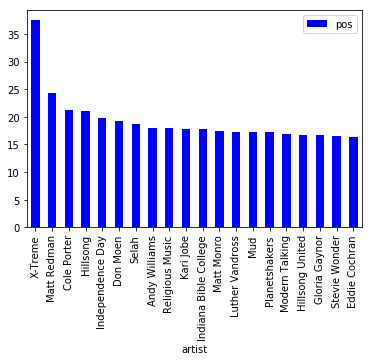

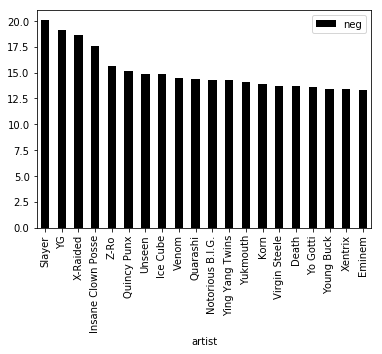

In [89]:
import matplotlib.pyplot as plt
#Plotting the 20 most positive artists and 20 most negative artists
#Pardon my lack of visualisation skills. Y-axis is Percentage of lyrics that are positive(1st fig) or negative(2nd fig)
ax = positivedf[:20].plot(x="artist", y="pos", kind="bar",color = 'blue')
bx = negativedf[:20].plot(x="artist", y="neg", kind="bar",color = 'black')

plt.show()

In [90]:
positive_artists = positivedf['artist'][:50].to_frame() #Take the top 50 most positive artists
temp_pos_lyrics = pd.merge(df, positive_artists, how='inner', on = 'artist') #get all their songs individual songs
temp_pos_lyrics = temp_pos_lyrics.sample(frac=1).reset_index(drop=True) #This shuffles all the rows so as to mix up the style of songs
arts_list = temp_pos_lyrics['artist'].unique() #sanity check just to see we don't have other artists
print(len(arts_list))
temp_pos_lyrics.head()

50


,artist,song,link,text
0,Planetshakers,I Want You To Know,/p/planetshakers/i+want+you+to+know_20612457.html,I want to show You \nThat my love for You is ...
1,Natalie Cole,My Baby Just Cares For Me,/n/natalie+cole/my+baby+just+cares+for+me_2026...,My baby don't care for shows \nMy baby don't ...
2,Frank Sinatra,A Million Dreams Ago,/f/frank+sinatra/a+million+dreams+ago_21068058...,"You told me it was so, a million dreams ago, ..."
3,Patsy Cline,"Love, Love, Love Me Honey Do",/p/patsy+cline/love+love+love+me+honey+do_2010...,My love is deeper than the world's deepest sea...
4,Luther Vandross,Power Of Love,/l/luther+vandross/power+of+love_20813078.html,When I say goodbye it is never for long \n'Ca...


In [91]:
pos_corpus = temp_pos_lyrics['text'].str.cat(sep='\n').lower() #create a corpus of all the lyrics that we have right now
print('corpus length:', len(pos_corpus))
chars = sorted(list(set(pos_corpus))) #Create a set of unique characters present in the corpus
print('total chars:', len(chars))

corpus length: 4438611
total chars: 50


In [92]:
artistLyrics.loc[artistLyrics['artist']=="Backstreet Boys"] #This is just to satisfy your curiosity on how negative or positive your fav artist is

,artist,text,pos,neg,neu
26,Backstreet Boys,"Once we were lovers just lovers we were \nOh,...",10.727084,2.681771,86.591146


In [93]:
#create a 2-way mapping of every character to a unique id (and unique id to a character)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maxlen = 40 # The window size
step = 3 # The steps between the windows
sentences = []
next_chars = []

# Take a sequence of 40 characters at a time and a step size of 3 to create the overlapping samples 
for i in range(0, len(pos_corpus) - maxlen, step):
    sentences.append(pos_corpus[i: i + maxlen]) # sequence of 40 characters 
    next_chars.append(pos_corpus[i + maxlen]) # the following character that we'll try to predict 
sentences = np.array(sentences)
next_chars = np.array(next_chars)
print('Number of sequences:', len(sentences))

Number of sequences: 1479524


In [94]:
#helper function to generate character level one-hot encoding for each sentence and next_character
def getdata(sentences, next_chars):
    X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return X, y


In [95]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file

#We use an LSTM with 128 hidden units followed by a dense layer the size of unique 
#characters and finally a softmax activation function. The loss we use is crossentropy
model = Sequential([
LSTM(128, input_shape=(maxlen, len(chars))),
Dense(len(chars)),
Activation('softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [96]:
# Use this to train the LSTM. Uncomment the next 5 lines if you're training the model from scratch
# X, y = getdata(sentences, next_chars) # Create the vectorised training data in the form of one hot encoded characters
# print(np.shape(X))
# batch_size = 128 #Using a batch size of 128
# history = model.fit(X, y,batch_size=128, epochs=30)
# model.save('positive_songs_generate.h5')

(1479524, 40, 50)


In [97]:
#Loading the presaved model. Comment this cell out if you're training the model from scratch
from keras.models import load_model
model = load_model('../input/trained-model/positive_songs_generate.h5')

In [98]:
#Get the first 40 characters from a random positive artist and use it as the seed for our model to predict the next letter
#Make sure that you're using 40 characters otherwise the results will be horrible
#In my experiments it does not go that well with random lyrics that you enter, so to make it fair, I use a random song as seed
sentence = df.iloc[np.random.random_integers(len(temp_pos_lyrics.index))]['text'].lower()[:40]
print(sentence)
x = np.zeros((1, maxlen, len(chars)))
for t, char in enumerate(sentence):
    x[0, t, char_indices[char]] = 1. #this generates the one hot vector of the sentence

love show me the way when i am lost and 


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 4671 + 1) instead
  after removing the cwd from sys.path.


In [99]:
#This function is used to add a bit of variance in the selection
#Without this the network will keep printing the same lines over and over
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    
    return np.argmax(probas)

In [100]:
variance = 0.50

generated = ''
original = sentence
window = sentence
# Predict the next 400 characters based on the seed
for i in range(400):
    x = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(window):
        x[0, t, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)[0]
    
    next_index = sample(preds, variance) #Innovate and get another character instead of the most likely one
#     next_index = np.argmax(preds) uncomment this line and comment the other line if you want some difference
    
    next_char = indices_char[next_index]

    generated += next_char
    window = window[1:] + next_char

print(original + generated)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


love show me the way when i am lost and song  
that hope that makes all the thing  
i am all away  
you are the one when i can make it  
i love you baby  
maybe i'm all alone and wears  
if i want to be the one in the street  
  
i won't let you think i know  
i love you more than a time  
the things we come  
the way to me you and the same old good  
i can see the world i know  
i want to know when i  
the world with the wind  
they're


In [101]:
#You'll see that it prints super sappy lyrics. It'd be interesting to see how the 
#lyrics would be if we used the most negative artists to generate the lyrics